# Data Augmentation Results
This notebook will run the experiment where data augmentation is applied to the limited dataset. The model of choice is ResNet18 with the limited MNIST dataset.

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
from torch_utils import *
from augmentation_utils import mnist_dataset, create_dataloader

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

In the creation of the `data_transforms`, we have the ability to use PyTorch's built in data augmentation tools to enhance the dataset. 

In [2]:
data_transforms_orig = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [3]:
data_transforms_random_crop = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(15, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(20, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [4]:
data_transforms_hori_flip = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [5]:
data_transforms_random_rot = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [6]:
data_transforms_random_erase = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [7]:
data_transforms_all = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(10, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(10, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.Normalize((0.5), (0.5))
    ]),
}

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


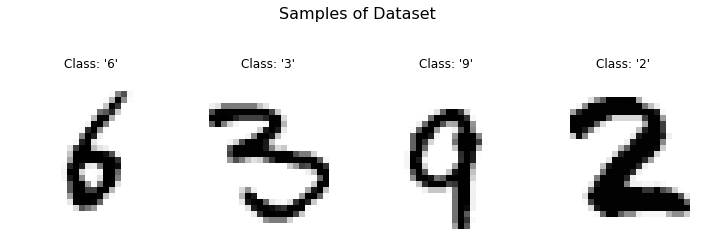

In [8]:
BATCH_SIZE = 32
limited_dataset_size = 650
pred_size=0.01

# use helper to create the dataloaders
tmp_dataset_orig = mnist_dataset(data_transforms_orig,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_orig, dataset_sizes, class_names = tmp_dataset_orig
dataloaders_orig = create_dataloader(dataset_orig, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_orig['val'])



Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


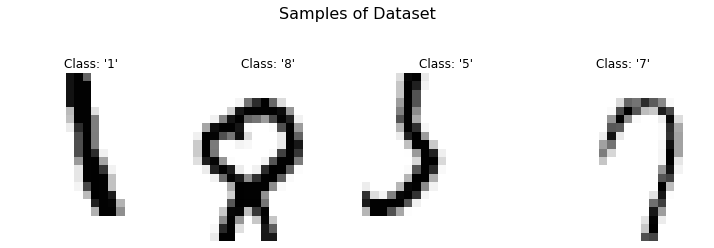

In [9]:
# use helper to create the dataloaders
tmp_dataset_random_crop = mnist_dataset(data_transforms_random_crop,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_crop, dataset_sizes, class_names = tmp_dataset_random_crop
dataloaders_random_crop = create_dataloader(dataset_random_crop, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_crop['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


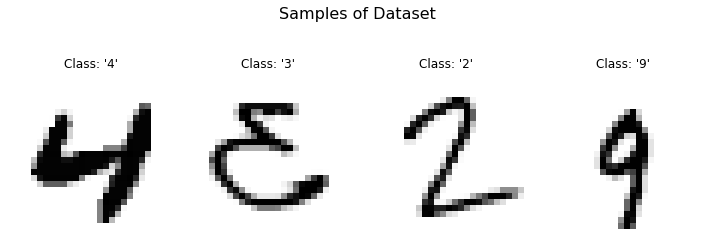

In [10]:
# use helper to create the dataloaders
tmp_dataset_hori_flip = mnist_dataset(data_transforms_hori_flip,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_hori_flip, dataset_sizes, class_names = tmp_dataset_hori_flip
dataloaders_hori_flip = create_dataloader(dataset_hori_flip, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_hori_flip['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


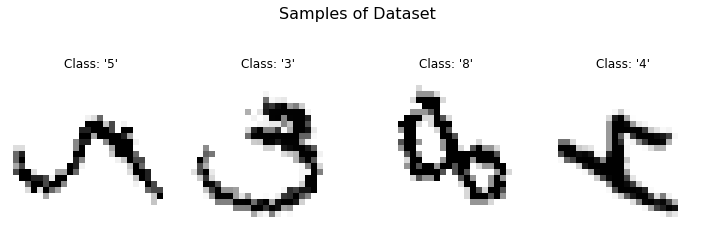

In [11]:
# use helper to create the dataloaders
tmp_dataset_random_rot = mnist_dataset(data_transforms_random_rot,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_rot, dataset_sizes, class_names = tmp_dataset_random_rot
dataloaders_random_rot = create_dataloader(dataset_random_rot, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_rot['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


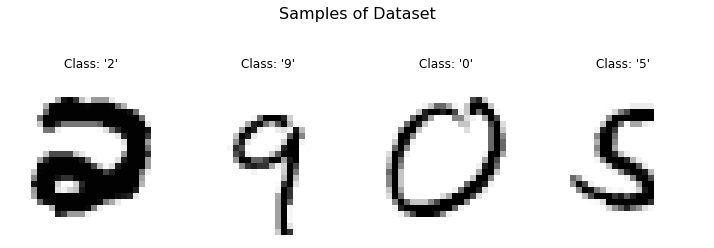

In [12]:
# use helper to create the dataloaders
tmp_dataset_random_erase = mnist_dataset(data_transforms_random_erase,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_random_erase, dataset_sizes, class_names = tmp_dataset_random_erase
dataloaders_random_erase = create_dataloader(dataset_random_erase, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_random_erase['val'])

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


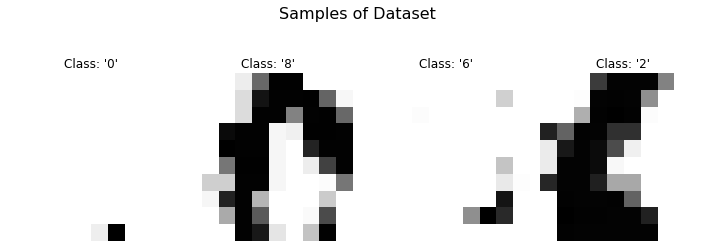

In [13]:
# use helper to create the dataloaders
tmp_dataset_all = mnist_dataset(data_transforms_all,
                           batch_size=BATCH_SIZE,
                           pred_size=pred_size,
                           sample_size=limited_dataset_size)
dataset_all, dataset_sizes, class_names = tmp_dataset_all
dataloaders_all = create_dataloader(dataset_all, BATCH_SIZE)

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders_all['val'])

In [14]:
# concatenate datasets augmented data and targets
dataset_new_train = dataset_orig['train']


dataset_all_train_data = dataset_all['train'].data
dataset_all_train_targets = dataset_all['train'].targets
#dataset_all_val = dataset_all['val'].dataset
#dataset_all_pred = dataset_all['pred'].dataset

dataset_orig_train_data = dataset_orig['train'].data
dataset_orig_train_targets = dataset_orig['train'].targets
dataset_orig_val = dataset_orig['val'].dataset
dataset_orig_pred = dataset_orig['pred'].dataset

#dataset_all_tot = {'train':dataset_all_train, 'val':dataset_all_val, 'pred':dataset_all_pred}
#dataset_orig_tot = {'train':dataset_orig_train, 'val':dataset_orig_val, 'pred':dataset_orig_pred}

#dataset_new_train.data = torch.utils.data.ConcatDataset([dataset_all_train_data, dataset_orig_train_data])
#dataset_new_train.targets = torch.utils.data.ConcatDataset([dataset_all_train_targets, dataset_orig_train_targets])

#data = np.concatenate([dataset_all_train_data, dataset_orig_train_data], axis=0)
#tgts = np.concatenate([dataset_all_train_targets, dataset_orig_train_targets], axis=0)
data = np.concatenate([dataset_orig_train_data, dataset_orig_train_data], axis=0)
tgts = np.concatenate([dataset_orig_train_targets, dataset_orig_train_targets], axis=0)
dataset_new_train.data = data
dataset_new_train.targets = tgts

dataset_new_tot = {'train':dataset_new_train, 'val':dataset_orig_val, 'pred':dataset_orig_pred}

#dataloaders_all = create_dataloader(dataset_all_tot, BATCH_SIZE)
#dataloaders_orig = create_dataloader(dataset_orig_tot, BATCH_SIZE)
dataloaders_new = create_dataloader(dataset_new_tot, BATCH_SIZE)


print(len(dataloaders_all['train']))
print(len(dataloaders_new['train']))


print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
#dataset_preview(dataloaders_new['train'])

print(next(iter(dataloaders_new)))

#inputs, classes = next(iter(dataloaders_new))


21
41
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
train


In [15]:
dataset_preview(dataloaders_new['train'])

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py", line 103, in __getitem__
    img = Image.fromarray(img.numpy(), mode='L')
AttributeError: 'numpy.ndarray' object has no attribute 'numpy'


## Train the Model on the Augmented Dataset
Fill in text

In [ ]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False

# create ResNet50 Model
model_ResNet18Lim = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Lim.fc.in_features
model_ResNet18Lim.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Lim.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Lim)

# train ResNet50 models
model_ResNet18Lim, results_df_ResNet18Lim,_ = train_model(device, model_ResNet18Lim, 
                                                    dataloaders_augmented, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Augmented'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_ResNet18Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_ResNet18Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

## Evaluate the Model
Fill in text

In [ ]:
# Evaluate the model using the prediction set held-off
model_ResNet18.eval()
dataloader_iter = iter(dataloaders_augmented['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18,inputs,labels,class_names) 
plt.plot()

## Conclusion
In closing, this notebook was intended to provide us with a baseline, a "zero" if you will. I think it is pretty clear from the work in this notebook that the ResNet-18 is a reasonable target model to finetune as a classifier for the MNIST dataset. Now, let's see how other methods can compare when dealing with a limited dataset for training.

## References:
[1] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [ ]:
 # training data (no cutout)
        train_dataset = datasets.CIFAR10(root='data/',
                                          train=True,
                                          transform=plain_transform,
                                          download=False)
​
        # create augmented data for each m (training data w/ cutout)
        for i in range(m-1):
            tmp = datasets.CIFAR10(root='data/',
                                   train=True,
                                   transform=aug_transform,
                                   download=False)
            # if we are subsampling, then randomly choose indices
            if aug_size < len(tmp):
                idxs = np.random.choice(len(tmp),aug_size, replace=False)
                tmp.data = [tmp.data[idx] for idx in idxs]
                tmp.targets = [tmp.targets[idx] for idx in idxs]
​
            # concatenate tue augmented data and targets
            data = np.concatenate([train_dataset.data, tmp.data], axis=0)
            tgts = np.concatenate([train_dataset.targets, tmp.targets], axis=0)
            train_dataset.data = data
            train_dataset.targets = tgts
                    
        # testing data (no cutout, original image)
        test_dataset = datasets.CIFAR10(root='data/',
                                          train=False,
                                          transform=plain_transform,
                                          download=False)
​
        # data loaders (input pipeline)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  pin_memory=True,
                                                  num_workers=2)
​
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=64,
                                                  shuffle=False,
                                                  pin_memory=True,
                                                  num_workers=2)
